In [ ]:
"""This project demonstrates a simple Recommender System using correlation filtering.
    It uses the movie ratings dataset to recommend movies to users based on their preferences.
"""

'This project demonstrates a simple Recomender System using collaborative filtering.\nIt uses the movie ratings dataset to recommend movies to users based on their preferences.'

In [2]:
# Import necessary libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [10]:
df.head()   

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [11]:
movie_titles = pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
# Merge movie titles with the main dataframe 
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)


In [14]:
# Exploratory Data Analysis 

# Movies with the highest number of ratings
sns.set_style('whitegrid')
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Aiqing wansui (1994)                                 5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
They Made Me a Criminal (1939)                       5.0
Name: rating, dtype: float64

In [15]:
# Movies with the most ratings 
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [16]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [18]:
# Add a 'num of ratings' column to the ratings DataFrame 
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


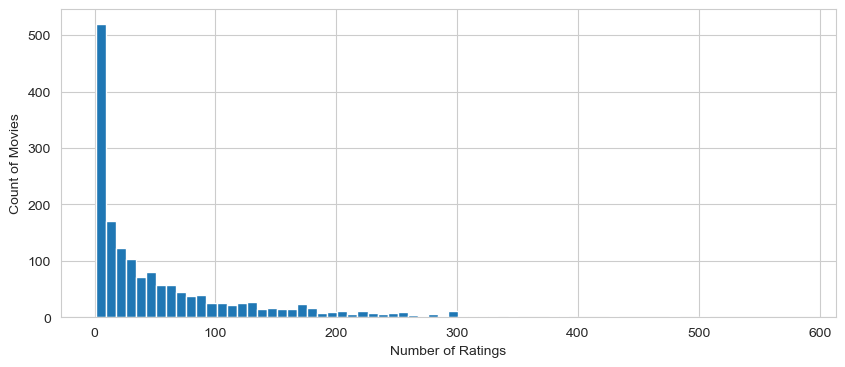

In [19]:
# Histogram of number of ratings 

plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()


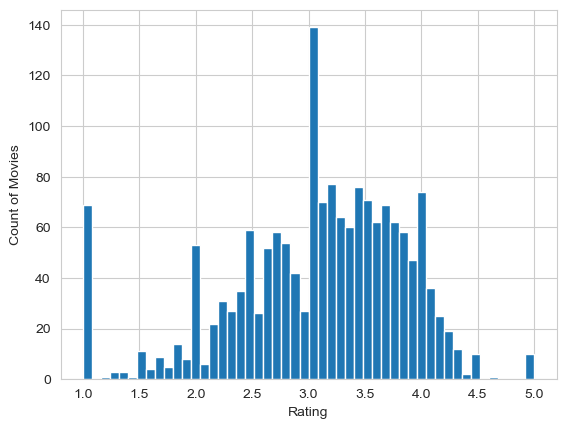

In [21]:
# Histogram of ratings 
ratings['rating'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Count of Movies')
plt.show()


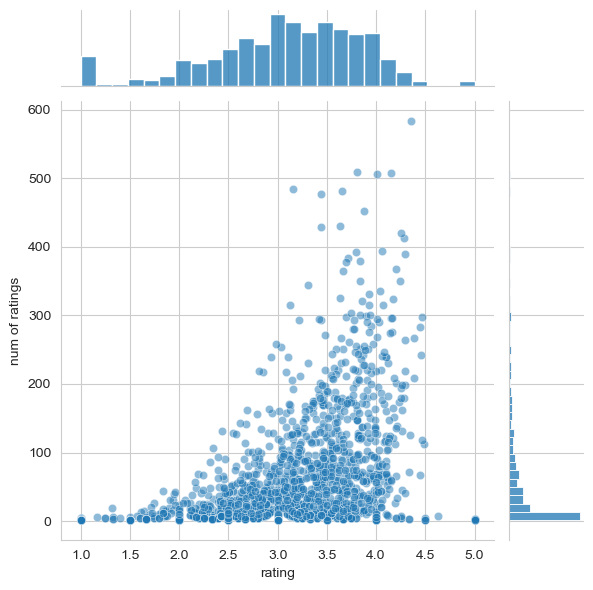

In [ ]:
# Jointplot of ratings vs number of ratings 
# This helps to visualize the relationship between the average rating of a movie and the number of ratings it has received.

sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)
plt.show()

In [25]:
# Create the movie-user matrix 

moviemat = df.pivot_table(index='user_id', columns='title', values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Top 10 movies with the highest number of ratings 
ratings.sort_values('num of ratings', ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [27]:
# 
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [28]:
# Corelation between Star Wars and other movies
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_starwars.head()  

c:\Coding_software\Anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Coding_software\Anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Coding_software\Anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Coding_software\Anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Coding_software\Anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [29]:
# Corelation between Liar Liar and other movies 
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)
similar_to_liarliar.head()

title
'Til There Was You (1997)    0.118913
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.469765
12 Angry Men (1957)          0.066272
187 (1997)                   0.175145
dtype: float64

In [ ]:
# Cleaning the corelation results by removing NaN values and creating a DataFrame

corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [32]:
# Top 10 movies similar to Star Wars based on correlation. 
# This wont be very accurate as some movies might have only a few ratings leading to high correlation by chance.
# Meaning the users who rated Star Wars also rated these movies, but not many users rated these movies. 
# To improve this, we can filter out movies with a low number of ratings.

corr_starwars.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
No Escape (1994),1.0
Man of the Year (1995),1.0
Cosi (1996),1.0
Commandments (1997),1.0
Golden Earrings (1947),1.0
"Scarlet Letter, The (1926)",1.0
Safe Passage (1994),1.0


In [33]:
# Filtering the results to only include movies with more than 100 ratings 

corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()    

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [35]:
# Filtering the results to only include movies with more than 100 ratings 
# Now we can see the top 10 movies that are most similar to Star Wars based on user ratings,
# while also having a significant number of ratings to ensure reliability.

corr_starwars = corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation', ascending=False)
corr_starwars.head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


In [37]:
# Similar process can be done for Liar Liar or any other movie to find similar movies based on user ratings. 

corr_liarliar = pd.DataFrame(similar_to_liarliar, columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar.head()


,Correlation,num of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [40]:
# Filtering the results to only include movies with more than 100 ratings 
# Now we can see the top 10 movies that are most similar to Liar Liar based on user ratings,
# while also having a significant number of ratings to ensure reliability.

corr_liarliar = corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation', ascending=False)
corr_liarliar


,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


In [ ]:
# Conclusion 
# This simple recommender system uses collaborative filtering to recommend movies based on user ratings.
# It identifies movies that are similar to a given movie by calculating the correlation between user ratings.
# By filtering out movies with a low number of ratings, we can improve the reliability of the recommender system. 
